# Sentiment Analysis - Cronos
In this notebook I will be making an sentiment analysis of the Cronos Group, that we scraped from various websites. I will be using two different techniques, to compare the acurracy of both the analysis.

1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of Words approach
2. Roberta Pretrained Model from 🤗
3. Hugging Face Pipeline

For more information on the used techniques:
- [VADER](https://github.com/cjhutto/vaderSentiment)
- [Hugging Face](https://huggingface.co/models)

# Step 0 - Import packages and read in data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [17]:
# Reading in the data and getting the first 5 rows
df = pd.read_csv('./cronos_reviews.csv')
df.head(5)

,id,company,date,opinion,rating,source
0,0,your oxygen,14/02/2015,December 2014 ben ik bij Your Oxygen ingeschre...,4.0,facebook
1,1,ARXUS INC.,29/04/2018,Custom professional IT solutions.,5.0,google
2,2,ARXUS INC.,29/04/2017,Belgian cloud at its best!,5.0,google
3,3,ARXUS INC.,29/04/2018,Fast growing company with motivated people. K...,5.0,google
4,4,ASTENA,2021-10-29,Ok,5.0,google


In [22]:
# Checking the first opinion
df['opinion'].values[0]

'December 2014 ben ik bij Your Oxygen ingeschreven, ze hadden me gecontacteerd ivm een werknemer van mij voor referenties....aangezien ik toen supervisor was bij Van Moer group. Na jaren dienst was ik toe aan een nieuwe boost en uitdaging in mijn loopbaan! Met dank aan Your Oxygen ben ik nu polyvalent medewerker bij Cogal Belgium Nv(gassector-chemie) met een direct vast bediendencontract en tal van extra legale voordelen'

In [21]:
# Looking at the shape of our dataset
print(df.shape)


(380, 6)


## Quick EDA

<function matplotlib.pyplot.show(close=None, block=None)>

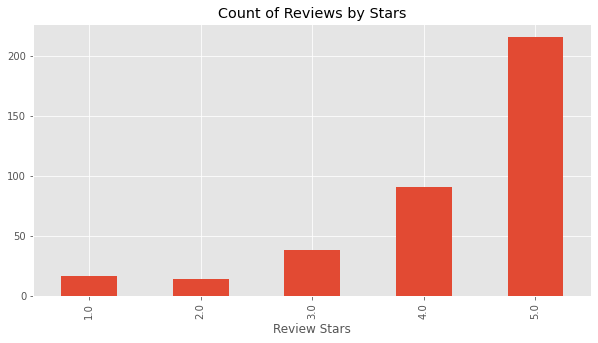

In [27]:
# Here I'm plotting the count of the reviews by stars
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar', 
          title='Count of Reviews by Stars', 
          figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show

We can see that the rating is most of the reviews are 4 or 5 star rating. So it's very biased towards positive reviews.

## Basic NLTK

Here I am going to do some basic NLTK, firstly I will do it on 1 example of our dataset

In [28]:

example = df['opinion'][50]
print(example)

Smooth collaboration procedures, minimum interaction, pays on time, helpful., No other interesting clients apart from European institutions


Here I will tokenize the opinion of our example. <br> 
It will just format the opinion so the computer can interpret it. <br>
Basically it just splits the sentence into parts of each word.

In [33]:
tokens = nltk.word_tokenize(example)
tokens[:10] # shows first 10 tokens

['Smooth',
 'collaboration',
 'procedures',
 ',',
 'minimum',
 'interaction',
 ',',
 'pays',
 'on',
 'time']

Part of speech tagging for each token and putting them into entities <br>
More info: [POS Tagging & Chunking](https://www.guru99.com/pos-tagging-chunking-nltk.html)

In [35]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Smooth', 'NNP'),
 ('collaboration', 'NN'),
 ('procedures', 'NNS'),
 (',', ','),
 ('minimum', 'JJ'),
 ('interaction', 'NN'),
 (',', ','),
 ('pays', 'VBZ'),
 ('on', 'IN'),
 ('time', 'NN')]

In [39]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  (GPE Smooth/NNP)
  collaboration/NN
  procedures/NNS
  ,/,
  minimum/JJ
  interaction/NN
  ,/,
  pays/VBZ
  on/IN
  time/NN
  ,/,
  helpful./NN
  ,/,
  (ORGANIZATION No/NNP)
  other/JJ
  interesting/JJ
  clients/NNS
  apart/RB
  from/IN
  (GPE European/JJ)
  institutions/NNS)


# Step 1 - VADER Sentiment Scoring
I used NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the opinion

- VADER uses a "Bag of Words" approach:
  - A text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.
  - Stop words are removed
  - Each word is scored and combined to a total score

Installing the necessary packages for the VADER Sentiment Analysis

In [41]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm # Progress bar

sia = SentimentIntensityAnalyzer()

Using some test strings to see how it performs

In [43]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

We can see that it analyses the text to be mostly positive. So it did a great job. <br>
Compound is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive)

In [44]:
sia.polarity_scores('This is the worst thing ever!')

{'neg': 0.468, 'neu': 0.532, 'pos': 0.0, 'compound': -0.6588}

Here the text is mostly negative and neutral and the compound is -0.6588. So it is more negative than positive. <br> 
Which is great because it seems to be working

Now I will be applying it to the example text from our dataset.

In [45]:
sia.polarity_scores(example)

{'neg': 0.111, 'neu': 0.754, 'pos': 0.136, 'compound': 0.128}

## Running the polarity score on our entire dataset